# <br> DBSCAN Clustering analysis performed for hotels' data coming from Bidroom DB: changing hotel type encoding for the one where order is meaningful<br>

### Information about data set:<br>
#### 1. Analysis was performed for sample about 1000 data from database. 
#### 2. Data were taken for two cities with the higest number of active hotels. <br> 


In [13]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
##libraries needed for clustering analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean
from DBCV.DBCV import DBCV

pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', True)


## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [15]:
file = pd.read_csv("Documents/clustering/dbscan/idGBdata.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   room_type_en         188 non-null    object 
 10  room_type_no         238 non-null    float64
 11  label                0 non-null      float64
 12  amenity              1038 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 105.8+ KB


#### <br> This analysis is provided for characteristics without the room_types that is why I am removing from original file thwo columns: room_type_no and room_type_en  <br>

In [16]:
fileWorking = fileWorking.drop(columns=["room_type_no","room_type_en"])

### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### This analysis is a first of such type for the data we are storing in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [17]:
fileWorking.head()

hotel_id  hotel_city  hotel_type hotel_country hotel_currency_code  \
0      5622        1174           4            GB                 GBP   
1      5630        1174           3            GB                 GBP   
2      5640        1174           4            GB                 GBP   
3      5671        1174           4            GB                 GBP   
4      5681        1174           5            GB                 GBP   

   hotel_lat  hotel_lon  hotel_distance  rooms_count  label  \
0  51.521259  -0.155856            3.12           34    NaN   
1  51.512071  -0.185206            4.30           45    NaN   
2  51.507706  -0.147138            1.67          106    NaN   
3  51.490098  -0.138130            1.39           72    NaN   
4  51.496872  -0.167604            2.89           28    NaN   

                                             amenity  
0  Free WIFI,Elevator / Lift,Air Conditioned,Free...  
1  Free WIFI,Elevator / Lift,Free WIFI,Elevator /...  
2  Free WIFI,Elevator / Lift,Parking,Fitness Room...  
3  Free WIFI,Elevator / Lift,Air Conditioned,Free...  
4  Free WIFI,Elevator / Lift,Parking,Pet Friendly...

#### I added ranks for each hotel type, ranks were from 1-5, such ranks I mapped for all hotels and the I used one hot encoding on such data. The hierarchy used in the current analysis was discussed and created in cooperation with business team and their hotels knowledge. <br>
#### Below I present hotel types and their ranks: 
##### {
##### "1-star_Hotel": #2, 
##### "2-star_Hotel": #2,
##### "3-star_Hotel": #3,,
##### "4-star_Hotel": #4, 
##### "5-star_Hotel", #5, 
##### "Apartment_Hotel_Type": #4,
##### "Hostel": #3,
##### "Motel": #3,
##### "Inn": #3,
##### "Bed&Breakfast": #3,
##### "Vacation_Rental": #4,
##### "Resort": #4,
##### "Other": #1,
##### "Aparthotel": #4,
##### "Boutique_Hotel": #5,
##### "Guesthouse": #3,
##### "Camping": #2,
##### "Villa": #5,
##### "Farm_Stay":#3,
##### "Hotel": #3
##### }

In [18]:
def hotel_type_to_columns(df):
    import category_encoders as ce
    hotel_type_dict = {
        1:2,
        2:2,
        3:3,
        4:4,
        5:5,
        8:4, 
        9:3,
        10:3,
        11:3,
        12:3,
        13:4,
        15:4,
        16:1, 
        23:4,
        25:5,
        30:3,
        32:2,
        33:5,
        34:3,
        36:3
    }   
    df["hotel_type_ordinary"] = df.hotel_type.map(hotel_type_dict)
    df = pd.get_dummies(df, prefix=["ht"], columns=['hotel_type_ordinary'])
    df.columns = df.columns.str.lower()
    df = df.drop(columns=["hotel_type"])
    return df


In [19]:
fileWorking = hotel_type_to_columns(fileWorking)

In [20]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_country        1040 non-null   object 
 3   hotel_currency_code  1040 non-null   object 
 4   hotel_lat            1040 non-null   float64
 5   hotel_lon            1040 non-null   float64
 6   hotel_distance       881 non-null    float64
 7   rooms_count          1040 non-null   int64  
 8   label                0 non-null      float64
 9   amenity              1038 non-null   object 
 10  ht_1                 1040 non-null   uint8  
 11  ht_2                 1040 non-null   uint8  
 12  ht_3                 1040 non-null   uint8  
 13  ht_4                 1040 non-null   uint8  
 14  ht_5                 1040 non-null   uint8  
dtypes: float64(4), int64(3), object(3), ui

#### <br> Amenities column contains a list of amenities for specific hotel in one cell. That Is why I put them to separate coulmns and gave True (1) if the hotel has that and False (0) otherwise <br>

#### <br> First I removed two rows that didn't have any amenities and label column that did not have any data <br>

In [21]:
fileWorking.loc[pd.isna(fileWorking["amenity"]), :].index

Int64Index([109, 111], dtype='int64')

In [22]:
fileWorking = fileWorking.drop([fileWorking.index[109], fileWorking.index[111]])

In [23]:
fileWorking = fileWorking.drop(columns=["label"])

In [24]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1039
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1038 non-null   int64  
 1   hotel_city           1038 non-null   int64  
 2   hotel_country        1038 non-null   object 
 3   hotel_currency_code  1038 non-null   object 
 4   hotel_lat            1038 non-null   float64
 5   hotel_lon            1038 non-null   float64
 6   hotel_distance       879 non-null    float64
 7   rooms_count          1038 non-null   int64  
 8   amenity              1038 non-null   object 
 9   ht_1                 1038 non-null   uint8  
 10  ht_2                 1038 non-null   uint8  
 11  ht_3                 1038 non-null   uint8  
 12  ht_4                 1038 non-null   uint8  
 13  ht_5                 1038 non-null   uint8  
dtypes: float64(3), int64(3), object(3), uint8(5)
memory usage: 86.2+ KB


### Creating separate sets of amenities for each city

#### Creating working file for Jakarta in Indonesia

In [25]:
fileWorkingID = fileWorking.loc[fileWorking.hotel_country=="ID"]
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 17 to 995
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             648 non-null    int64  
 1   hotel_city           648 non-null    int64  
 2   hotel_country        648 non-null    object 
 3   hotel_currency_code  648 non-null    object 
 4   hotel_lat            648 non-null    float64
 5   hotel_lon            648 non-null    float64
 6   hotel_distance       636 non-null    float64
 7   rooms_count          648 non-null    int64  
 8   amenity              648 non-null    object 
 9   ht_1                 648 non-null    uint8  
 10  ht_2                 648 non-null    uint8  
 11  ht_3                 648 non-null    uint8  
 12  ht_4                 648 non-null    uint8  
 13  ht_5                 648 non-null    uint8  
dtypes: float64(3), int64(3), object(3), uint8(5)
memory usage: 53.8+ KB


#### Creating working file for London in Great Britain

In [26]:
fileWorkingGB = fileWorking.loc[fileWorking.hotel_country=="GB"]
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 1039
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             390 non-null    int64  
 1   hotel_city           390 non-null    int64  
 2   hotel_country        390 non-null    object 
 3   hotel_currency_code  390 non-null    object 
 4   hotel_lat            390 non-null    float64
 5   hotel_lon            390 non-null    float64
 6   hotel_distance       243 non-null    float64
 7   rooms_count          390 non-null    int64  
 8   amenity              390 non-null    object 
 9   ht_1                 390 non-null    uint8  
 10  ht_2                 390 non-null    uint8  
 11  ht_3                 390 non-null    uint8  
 12  ht_4                 390 non-null    uint8  
 13  ht_5                 390 non-null    uint8  
dtypes: float64(3), int64(3), object(3), uint8(5)
memory usage: 32.4+ KB


In [27]:
def handleAmenities(df):
    import re
    amenities =  []
    for num, x in enumerate(df["amenity"]):
        try:
            x = x.split(sep=',')
            amenities = amenities + x
        except:
            amenities.append(x)
    amenities = list(set(amenities))  
    for x in amenities:
        com = '(.*)?('+ x +')(.*)?'
        df[x]=[1 if re.search(com,a) is not None else 0 for a in df["amenity"]]
    df = df.drop(columns=["amenity"])
    return df

amenitiesID = handleAmenities(fileWorkingID[["hotel_id","amenity"]])
amenitiesGB = handleAmenities(fileWorkingGB[["hotel_id","amenity"]])

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Creating final dataset for clustering analysis

In [28]:
# for Jakarta
fileWorkingID = fileWorkingID.merge(amenitiesID, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingID.columns = fileWorkingID.columns.str.lower()

# for London
fileWorkingGB = fileWorkingGB.merge(amenitiesGB, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingGB.columns = fileWorkingGB.columns.str.lower()

## Data Cleaning

### Removing duplicates

In [29]:
# for Jakarta
filesWorkingIDCleaned = fileWorkingID.drop_duplicates(subset=["hotel_id"], keep="first")
# for London
filesWorkingGBCleaned = fileWorkingGB.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

#### handling information for hotel_currency_code

In [30]:
filesWorkingIDCleaned["hotel_currency_code"].isna().sum()

0

In [31]:
# for Jakarta
filesWorkingIDCleaned = pd.get_dummies(filesWorkingIDCleaned,prefix=["curr"], columns=["hotel_currency_code"])
# # for London
filesWorkingGBCleaned = pd.get_dummies(filesWorkingGBCleaned,prefix=["curr"], columns=["hotel_currency_code"])

#### handling information for hotel_country

In [32]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["hotel_country", "hotel_city"])
filesWorkingGBCleaned = filesWorkingGBCleaned.drop(columns=["hotel_country", "hotel_city"])

#### handling information for rooms_count

In [33]:
filesWorkingIDCleaned["rooms_count"].isna().sum()

0

#### handling information for hotel_distance 

In [34]:
filesWorkingIDCleaned["hotel_distance"].value_counts(dropna=False)

3.90     20
4.15     14
10.84    14
NaN      12
4.16      7
         ..
12.00     1
3.33      1
8.51      1
6.91      1
2.43      1
Name: hotel_distance, Length: 383, dtype: int64

In [35]:
filesWorkingGBCleaned["hotel_distance"].value_counts(dropna=False)

NaN     147
3.84      4
1.60      3
4.03      3
2.39      3
       ... 
4.15      1
1.88      1
2.68      1
3.29      1
1.32      1
Name: hotel_distance, Length: 201, dtype: int64

#### There is lack of calculated hotel distance for 147 hotels in London and 12 for Jakarta so I used mean calculated per city o fill that data

In [36]:
mean1  = filesWorkingIDCleaned["hotel_distance"].mean()
mean2  = filesWorkingGBCleaned["hotel_distance"].mean()
filesWorkingIDCleaned["hotel_distance"].fillna(mean2, inplace=True)
filesWorkingGBCleaned["hotel_distance"].fillna(mean1, inplace=True)

#### dropping columns that have only one value and it is 0 

In [37]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["ht_5"])

#### dropping hotel_id for all data sets

In [38]:
indonesia = filesWorkingIDCleaned.drop(columns=["hotel_id"])
gb = filesWorkingGBCleaned.drop(columns=["hotel_id"])

### Visualize heatmap for all hotels characteristics in Jakarta

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in Jakarta')

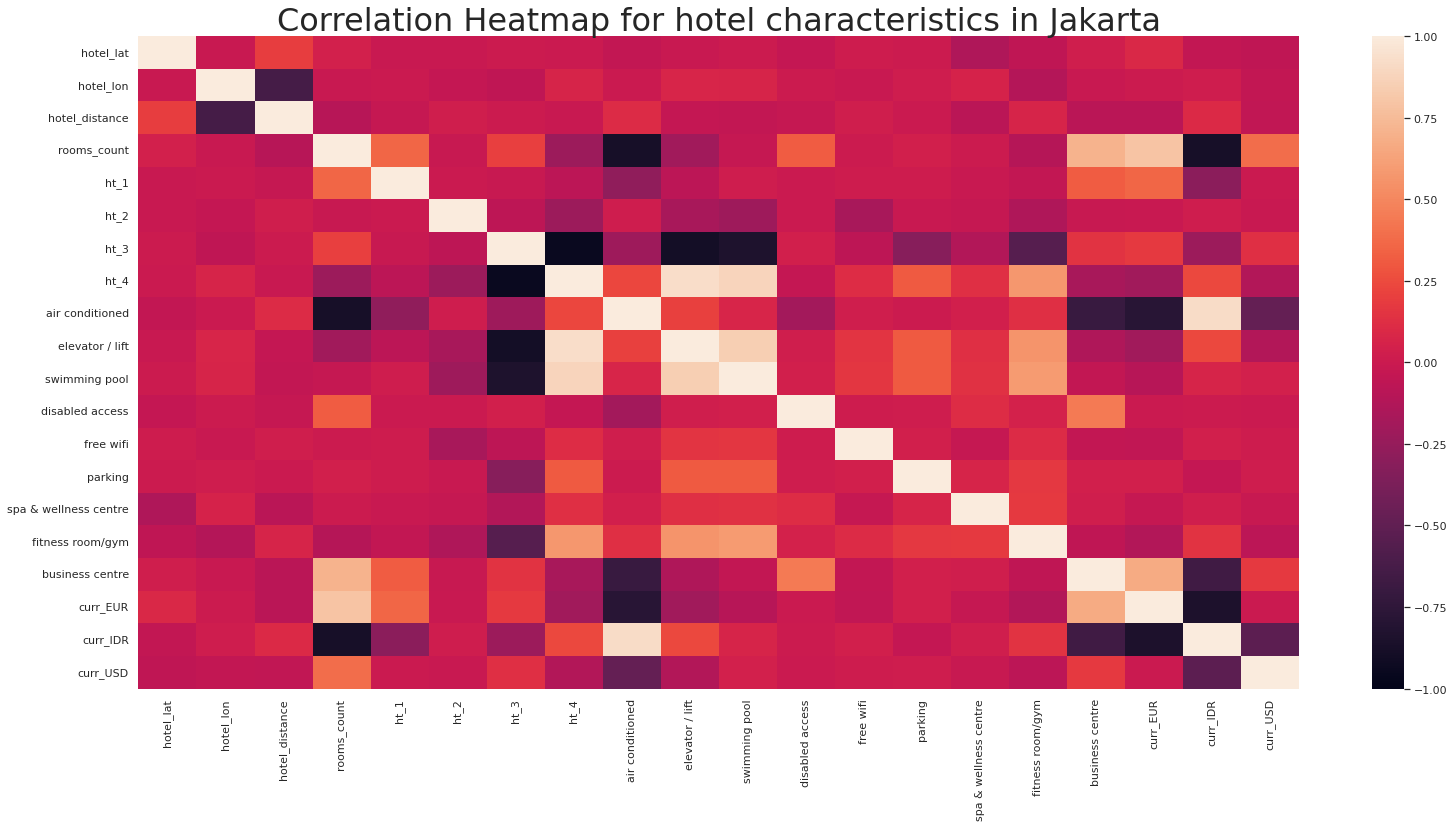

In [39]:

plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 36})
heatmap = sns.heatmap(indonesia.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in Jakarta", fontdict={"fontsize":32})

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in London')

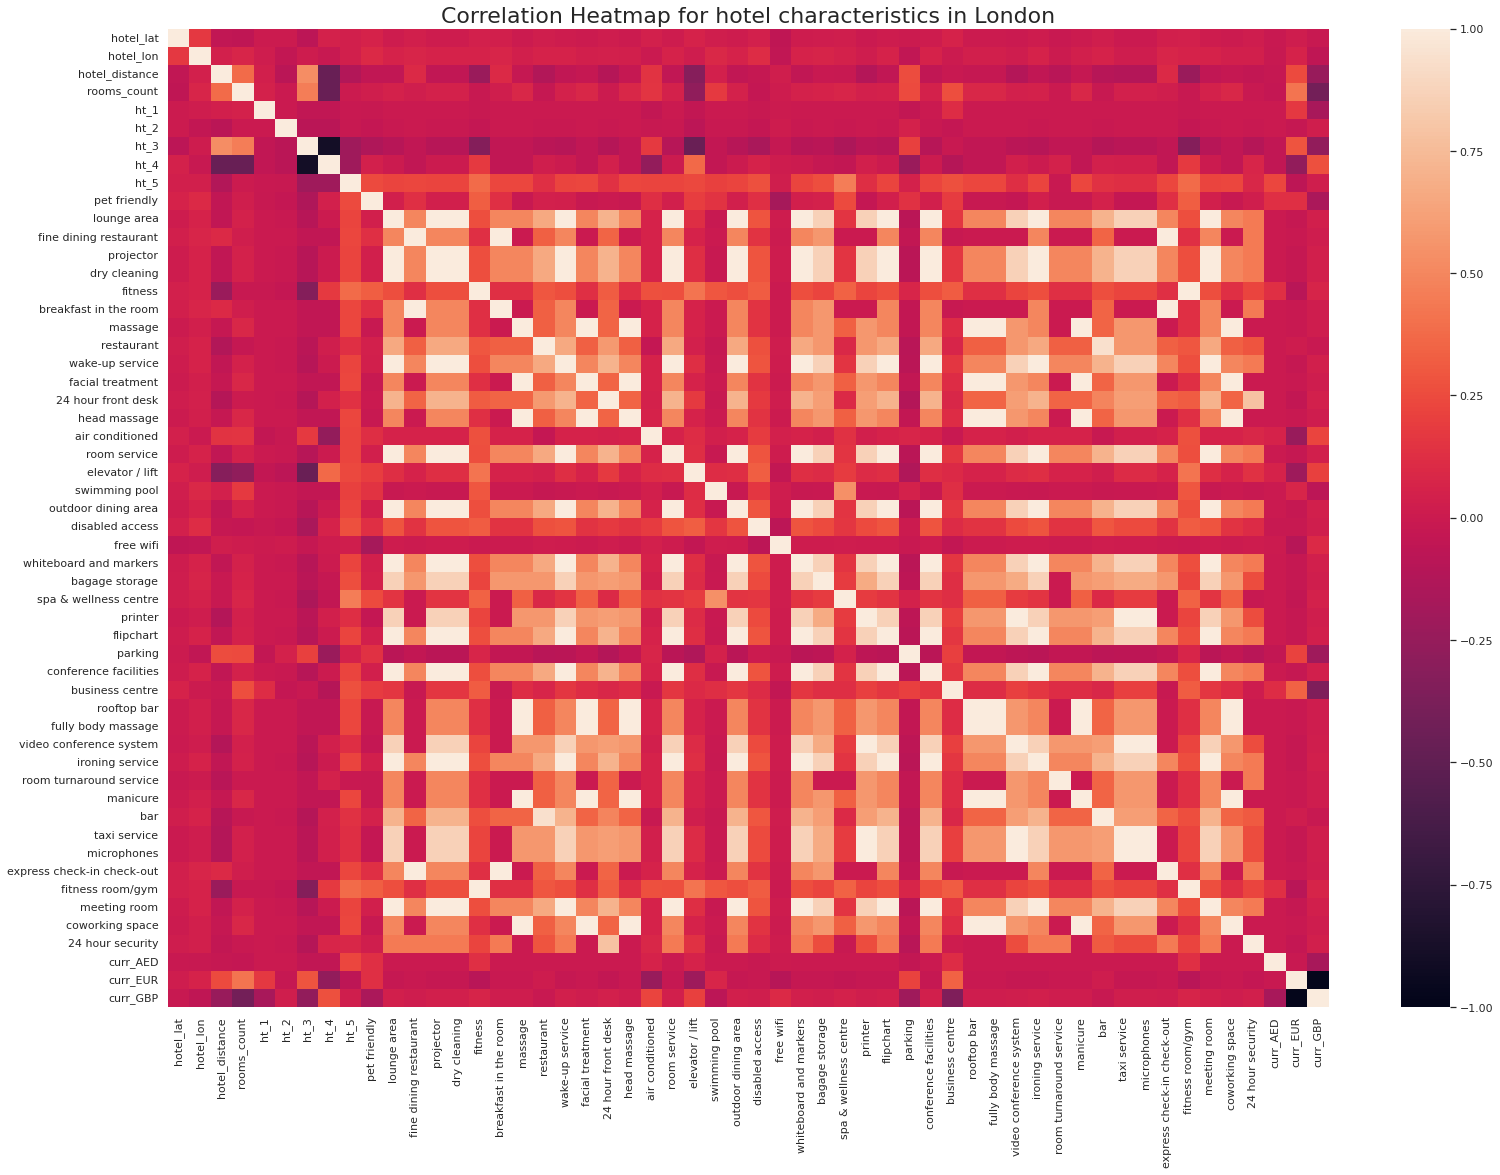

In [40]:

plt.figure(figsize=(26, 18))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(gb.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in London", fontdict={"fontsize":22})

### <br> Concusions: 
#### this time I showed the correlaton between amenities separately for each city:
#### - both cities shows different amount of amenities available in given hotels;
#### - most of amenities are highly correlated for London, so they are showing the same segment of characteristics;
#### - the same pairs of amenities showed slightly different level of correlation for Jakarta and London but the trend was similar for both cities<br>


## Data Reduction

#### <br> **calc_vif** - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was higher than 5.
#### **reduce_dimensions_by_pca** -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables. <br>

In [41]:
def calc_vif(df):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[(vif["VIF"].isnull())]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    if "const" in col_names:       
        const_to_remove = col_names.index("const")
        del col_names[const_to_remove]

    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

In [42]:
gbToReduce = calc_vif(gb)
idToReduce = calc_vif(indonesia)

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### <br> Removing from the working file variables which are highly correlated <br>

In [43]:
idReduced = select_variables(filesWorkingIDCleaned, idToReduce)
gbReduced = select_variables(filesWorkingGBCleaned, gbToReduce)

#### Creating copy that is not containing Hotel id for the analysis

In [44]:
idReducedAnalysis = idReduced.drop(columns=["hotel_id"])
gbReducedAnalysis = gbReduced.drop(columns=["hotel_id"])

In [45]:
#### ploting correlation heatmap for final hotel characteristics

(648, 13)

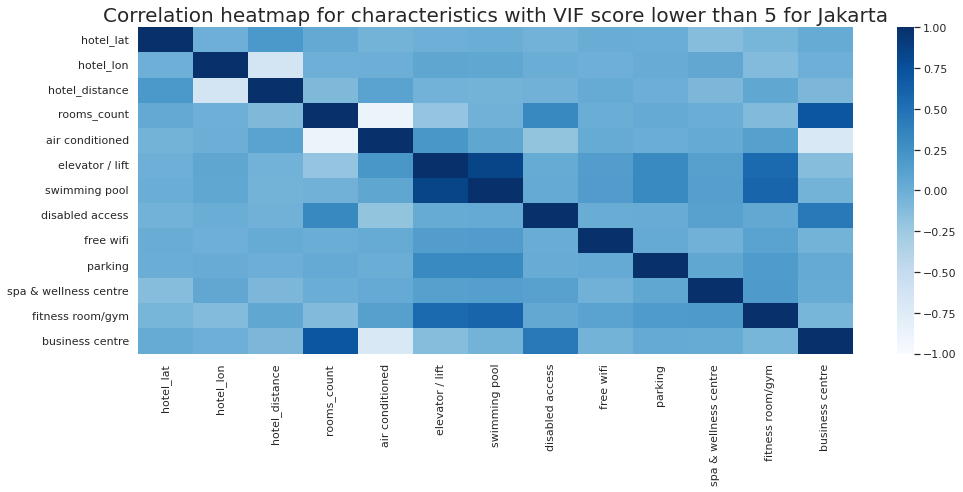

In [46]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(idReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for Jakarta", fontsize=20)
idReducedAnalysis.shape

(390, 13)

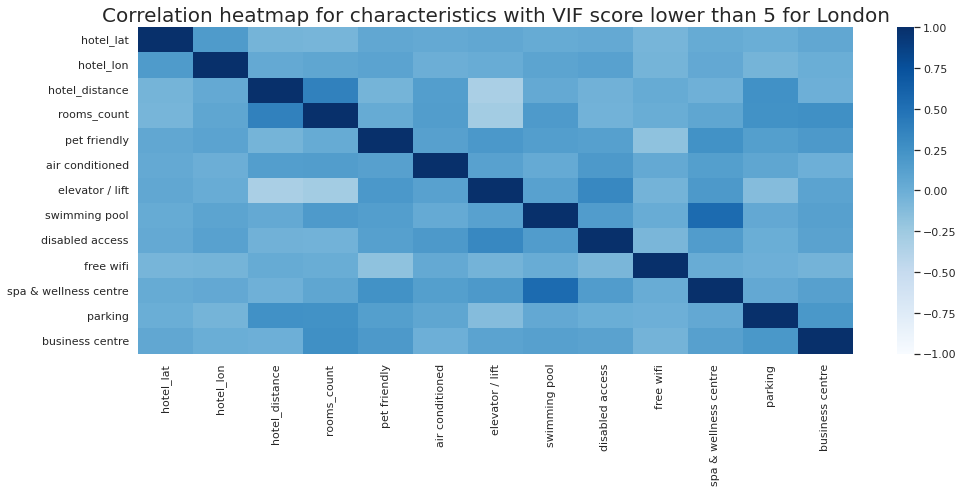

In [47]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gbReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for London", fontsize=20)
gbReducedAnalysis.shape

### <br> Conclusions:
#### - this time  function detecting multcolinearity was removing characteristics VIF score higher that 5 what was recomended by documantation, it reduced the dimentions to 9 for Jakarta, 14 for London <br>


## Standarizing data

In [48]:
scaler = StandardScaler()
# standarizing data from Jakarta
indo_std = scaler.fit_transform(idReducedAnalysis)
# standarizing data from London
gb_std = scaler.fit_transform(gbReducedAnalysis)

## First removing Dimentions with PCA for Jakarta

In [49]:
pca_indoesia = PCA(n_components=0.95)
train_pca_indonesia = pca_indoesia.fit_transform(indo_std)
train_pca_indonesia[:1]

array([[ 7.95506727, 10.44159333,  1.18780665,  8.33347921, -2.38154051,
         9.05288163, -3.55850702,  9.13681254,  0.22672492, -0.51728141]])

### Showing how many components is responsible for  95% of variance

In [50]:
pca_indoesia.n_components_

10

### Explained Variance

In [51]:
results = pd.DataFrame(data={"explained_variance_ratio":pca_indoesia.explained_variance_ratio_})
results["cumulative"] = results["explained_variance_ratio"].cumsum()
results["component"] = results.index + 1
results

explained_variance_ratio  cumulative  component
0                  0.225451    0.225451          1
1                  0.185026    0.410477          2
2                  0.129999    0.540476          3
3                  0.088758    0.629234          4
4                  0.075131    0.704365          5
5                  0.068752    0.773117          6
6                  0.063751    0.836868          7
7                  0.061787    0.898655          8
8                  0.035267    0.933923          9
9                  0.024654    0.958577         10

In [52]:
indonesia_reduced = pd.DataFrame(data=train_pca_indonesia.flatten())

## Second removing Dimentions with t-SNE algorythm

In [53]:
tsne = TSNE(n_components=2, verbose=1)
indonesia_tsne = tsne.fit_transform(train_pca_indonesia)

/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 648 samples in 0.003s...
[t-SNE] Computed neighbors for 648 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 648 / 648
[t-SNE] Mean sigma: 0.358257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.293949
[t-SNE] KL divergence after 1000 iterations: 0.234580


In [54]:
indonesia_train_tsne_df = pd.DataFrame(data=np.c_[indonesia_tsne], columns = ["tsne_1", "tsne_2"])
indonesia_train_tsne_df

tsne_1     tsne_2
0   -17.943008  -3.884451
1    -8.066834  14.026182
2    23.745781   3.636742
3   -15.585433   8.348328
4    17.802837  15.971037
..         ...        ...
643  25.817196  -7.461418
644  26.264654  -8.416538
645  26.359390  -8.298128
646  26.140022  -8.277899
647  26.298002  -8.336522

[648 rows x 2 columns]

## First removing Dimentions with PCA for London

In [55]:
pca_gb = PCA(n_components=0.95)
train_pca_gb = pca_gb.fit_transform(gb_std)
train_pca_gb[:1]

array([[-0.18661105, -1.39863019, -0.40137586,  0.43415308,  0.80327104,
        -0.28840173, -0.48077823,  0.04361668, -0.88163411, -0.65660846,
         0.42893955,  0.29199019]])

### Showing how many components explains 95% of variance

In [56]:
pca_gb.n_components_

12

### Explained Variance

In [57]:
results = pd.DataFrame(data={"explained_variance_ratio":pca_gb.explained_variance_ratio_})
results["cumulative"] = results["explained_variance_ratio"].cumsum()
results["component"] = results.index + 1
results

explained_variance_ratio  cumulative  component
0                   0.163587    0.163587          1
1                   0.147823    0.311409          2
2                   0.094783    0.406192          3
3                   0.087519    0.493710          4
4                   0.086272    0.579982          5
5                   0.074101    0.654083          6
6                   0.069066    0.723149          7
7                   0.061459    0.784608          8
8                   0.059436    0.844043          9
9                   0.045930    0.889973         10
10                  0.041282    0.931255         11
11                  0.037282    0.968537         12

In [58]:
gb_reduced = pd.DataFrame(data=train_pca_gb.flatten())

## Second removing dimentions with t-SNE algorythm

In [59]:
tsne = TSNE(n_components=2, verbose=1)
gb_tsne = tsne.fit_transform(train_pca_gb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 390 samples in 0.001s...
[t-SNE] Computed neighbors for 390 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 1.137709


/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/agata/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.129517
[t-SNE] KL divergence after 1000 iterations: 0.374931


In [60]:
gb_train_tsne_df = pd.DataFrame(data=np.c_[gb_tsne], columns = ["tsne_1", "tsne_2"])
gb_train_tsne_df

tsne_1     tsne_2
0   -10.209219  -2.104695
1    -8.641511 -20.256075
2    -3.542606  -9.533476
3    -9.270043  -3.000863
4    -3.529362  -9.548394
..         ...        ...
385   1.375297  21.578249
386  -4.272665  -9.853694
387   1.562316 -12.475736
388 -21.837509  -8.313134
389   4.788738   3.851804

[390 rows x 2 columns]

### <br>Conclusions:
#### - After PCA for Jakarta only 8 out of 9 characteristics were responsible for 95% of varianve in data, and how it is visible from cumulative component all of them more or less play the same role in variance
####  - After PCA  for London only 13  out of 14 characteristics were responsible for 95% of varianve in data, and how it is visible from cumulative component all of them more or less play the same role in variance <br>

## DBSCAN Clustering analysis

### <br>There were performed 2 analysis:
#### 1. for Jakarta
#### 2. for London<br>

### 1. Jakarta

#### Calculating the eps and min_samples: this time I reduced dimentions to 2 using t-SNE algoithm that is why as a minimal number of samples was taken 4.  To calculate the average distance between each point and its n_neighbors is generally used the NearestNeighbors 

In [61]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(indonesia_tsne)
distances, indices = neighbors_fit.kneighbors(indonesia_tsne)

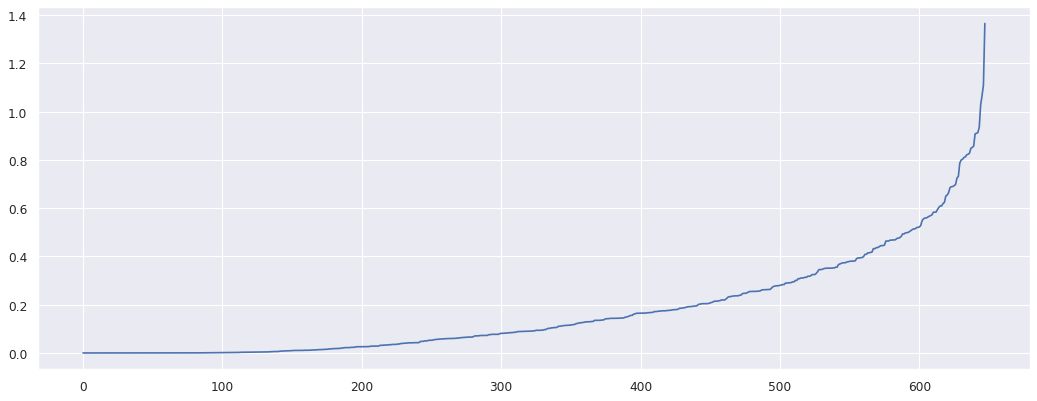

In [62]:
plt.figure(figsize=(16, 6), dpi=80)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [63]:
cluster = DBSCAN(eps=0.9,min_samples=4)
labels = cluster.fit(indonesia_tsne)

In [64]:
np.unique(labels.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [65]:
n_clusters_ = len(set(labels.labels_)) - (1 if -1 in labels.labels_ else 0)
n_noise_ = list(labels.labels_).count(-1)

In [66]:
dbscan_score = DBCV(indonesia_tsne, labels.labels_, dist_function=euclidean)

In [67]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Estimated DBCV: %0.3f" % dbscan_score)

Estimated number of clusters: 48
Estimated number of noise points: 51
Estimated DBCV: 0.277


In [68]:
idReduced["cluster"] = labels.labels_

In [69]:
idReduced

hotel_id  hotel_lat   hotel_lon  hotel_distance  rooms_count  \
0       52765  -6.255336  106.810825        6.180000          203   
1      506274  -6.175420  106.729023       13.450000            1   
2      506275  -6.208347  106.818008        3.020000            1   
3      506278  -6.223455  106.784432        6.840000            1   
4      506279  -6.162375  106.832172        5.650000            1   
..        ...        ...         ...             ...          ...   
643    589802  -6.221410  106.815778        3.931276          214   
644    589803  -6.127151  106.790440        3.931276          300   
645    589804  -6.264619  106.782179        3.931276          311   
646    589805  -6.187198  106.821936        3.931276          222   
647    589810  -6.141225  106.853436        3.931276          272   

     air conditioned  elevator / lift  swimming pool  disabled access  \
0                  1                1              1                1   
1                  1                1              1                0   
2                  1                1              1                0   
3                  1                1              1                0   
4                  1                1              1                0   
..               ...              ...            ...              ...   
643                0                0              1                0   
644                0                0              0                0   
645                0                0              1                0   
646                0                0              0                0   
647                0                0              1                0   

     free wifi  parking  spa & wellness centre  fitness room/gym  \
0            1        1                      1                 1   
1            1        1                      0                 1   
2            1        1                      0                 0   
3            1        1                      0                 1   
4            1        1                      0                 0   
..         ...      ...                    ...               ...   
643          1        1                      0                 0   
644          1        1                      0                 0   
645          1        1                      0                 0   
646          1        1                      0                 0   
647          1        1                      0                 0   

     business centre  cluster  
0                  1       -1  
1                  0        0  
2                  0        1  
3                  0        2  
4                  0        3  
..               ...      ...  
643                0       47  
644                1       47  
645                1       47  
646                1       47  
647                1       47  

[648 rows x 15 columns]

In [70]:
indonesia_train_tsne_df["cluster"] = labels.labels_
indonesia_train_tsne_df

tsne_1     tsne_2  cluster
0   -17.943008  -3.884451       -1
1    -8.066834  14.026182        0
2    23.745781   3.636742        1
3   -15.585433   8.348328        2
4    17.802837  15.971037        3
..         ...        ...      ...
643  25.817196  -7.461418       47
644  26.264654  -8.416538       47
645  26.359390  -8.298128       47
646  26.140022  -8.277899       47
647  26.298002  -8.336522       47

[648 rows x 3 columns]

In [71]:
idReduced["cluster"].unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 33, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 35, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 45, 47])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


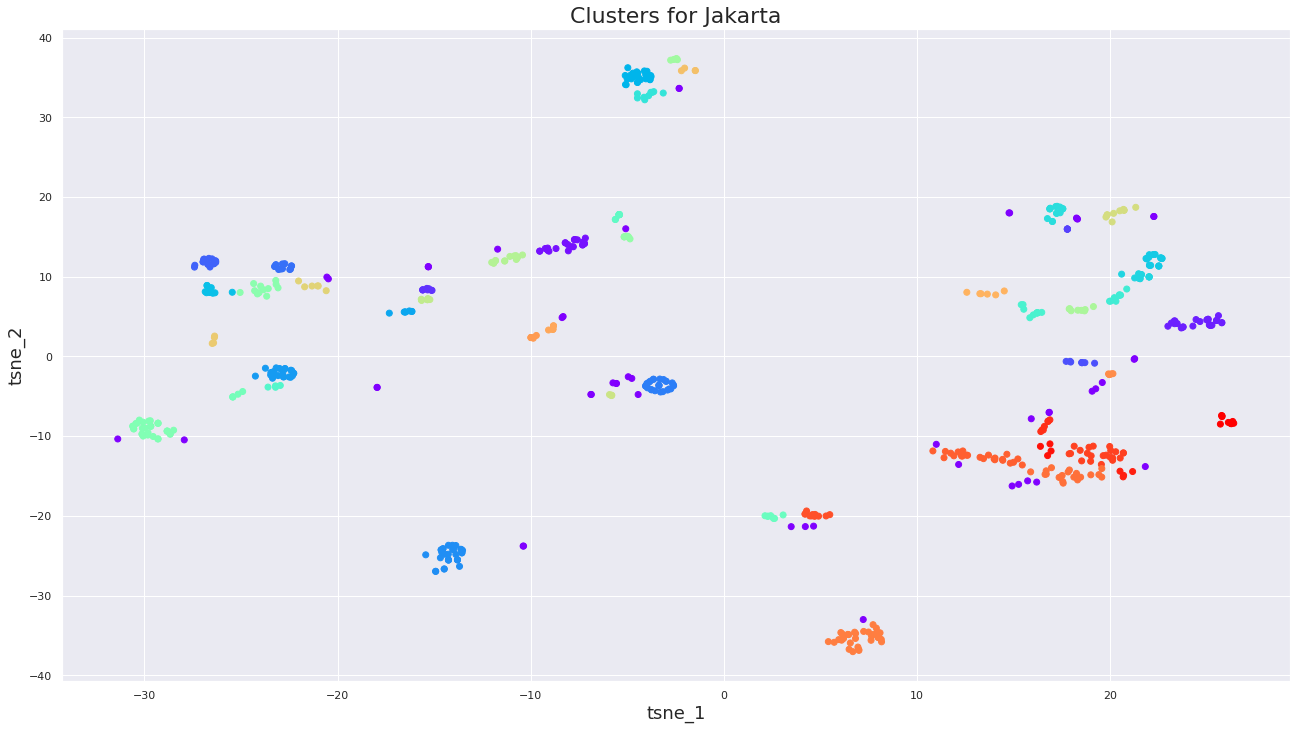

In [72]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=indonesia_train_tsne_df, x="tsne_1", y="tsne_2", c= "cluster", cmap = "rainbow", label = "cluster")
plt.xlabel("tsne_1",**axis_font)
plt.ylabel("tsne_2",**axis_font)
plt.title("Clusters for Jakarta", fontdict={"fontsize":22})
plt.show()

In [73]:
# visualizing the plot in plotly
px.scatter(indonesia_train_tsne_df, x="tsne_1", y="tsne_2", color = "cluster",  template = "plotly_dark", title = "Clusters for Jakarta")

### London

In [74]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(gb_tsne)
distances, indices = neighbors_fit.kneighbors(gb_tsne)

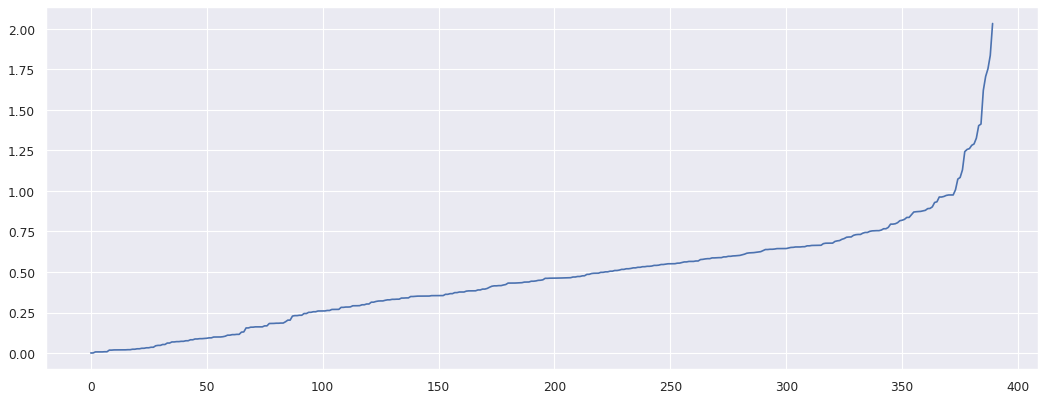

In [75]:
plt.figure(figsize=(16, 6), dpi=80)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [76]:
cluster = DBSCAN(eps=2,min_samples=4)
labels = cluster.fit(gb_tsne)

In [77]:
np.unique(labels.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19])

In [78]:
n_clusters_ = len(set(labels.labels_)) - (1 if -1 in labels.labels_ else 0)
n_noise_ = list(labels.labels_).count(-1)

In [79]:
dbscan_score = DBCV(gb_tsne, labels.labels_, dist_function=euclidean)

In [80]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Estimated DBCV: %0.3f" % dbscan_score)

Estimated number of clusters: 20
Estimated number of noise points: 14
Estimated DBCV: 0.056


In [81]:
gbReduced["cluster"] = labels.labels_

In [82]:
gbReduced

hotel_id  hotel_lat  hotel_lon  hotel_distance  rooms_count  \
0        5622  51.521259  -0.155856        3.120000           34   
1        5630  51.512071  -0.185206        4.300000           45   
2        5640  51.507706  -0.147138        1.670000          106   
3        5671  51.490098  -0.138130        1.390000           72   
4        5681  51.496872  -0.167604        2.890000           28   
..        ...        ...        ...             ...          ...   
385    589981  51.508232   0.043758        6.915566          225   
386    590977  51.516015  -0.118570        1.840000            0   
387    592390  51.543948  -0.152331        5.200000            1   
388    592405  51.511208  -0.119345        1.320000            0   
389    592406  51.506490  -0.071724        3.840000            0   

     pet friendly  air conditioned  elevator / lift  swimming pool  \
0               0                1                1              0   
1               0                0                1              0   
2               1                0                1              0   
3               0                1                1              0   
4               1                0                1              0   
..            ...              ...              ...            ...   
385             0                0                0              0   
386             1                1                1              0   
387             1                0                0              0   
388             0                0                0              0   
389             0                0                0              0   

     disabled access  free wifi  spa & wellness centre  parking  \
0                  0          1                      0        0   
1                  0          1                      0        0   
2                  0          1                      0        1   
3                  0          1                      0        0   
4                  0          1                      0        1   
..               ...        ...                    ...      ...   
385                0          1                      0        1   
386                0          1                      0        1   
387                0          1                      0        0   
388                1          1                      0        0   
389                0          1                      0        1   

     business centre  cluster  
0                  0        0  
1                  0        1  
2                  1        2  
3                  0        0  
4                  1        2  
..               ...      ...  
385                0       17  
386                1        2  
387                0       11  
388                0       12  
389                0        9  

[390 rows x 15 columns]

In [83]:
gb_train_tsne_df["cluster"] = labels.labels_
gb_train_tsne_df

tsne_1     tsne_2  cluster
0   -10.209219  -2.104695        0
1    -8.641511 -20.256075        1
2    -3.542606  -9.533476        2
3    -9.270043  -3.000863        0
4    -3.529362  -9.548394        2
..         ...        ...      ...
385   1.375297  21.578249       17
386  -4.272665  -9.853694        2
387   1.562316 -12.475736       11
388 -21.837509  -8.313134       12
389   4.788738   3.851804        9

[390 rows x 3 columns]

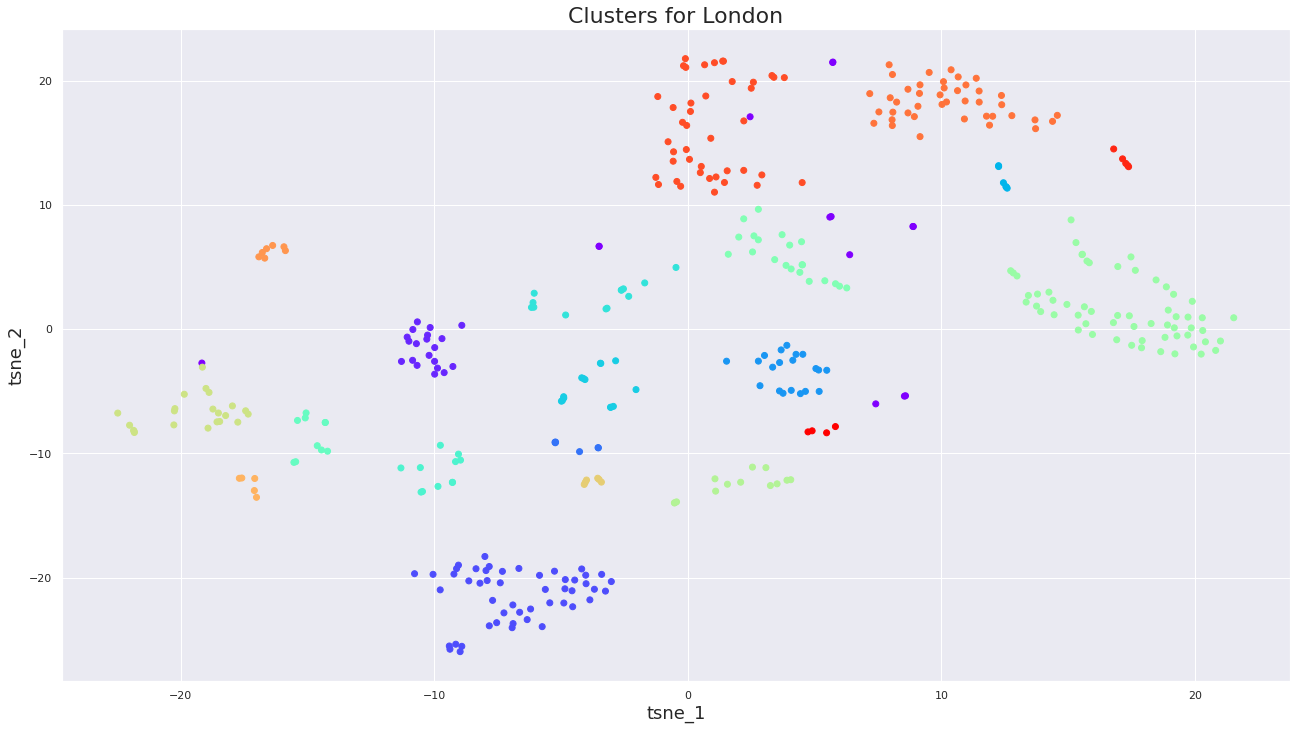

In [84]:
plt.figure(figsize=(22, 12))
axis_font = {'fontname':'Arial', 'size':'18'}
plt.scatter(data=gb_train_tsne_df, x="tsne_1", y="tsne_2", c= "cluster", cmap = "rainbow", label = "cluster")
plt.xlabel("tsne_1",**axis_font)
plt.ylabel("tsne_2",**axis_font)
plt.title("Clusters for London", fontdict={"fontsize":22})
plt.show()

In [85]:
#visualizing data also with plotly express
import plotly.express as px
px.scatter(gb_train_tsne_df, x="tsne_1", y="tsne_2", color = "cluster",  template = "plotly_dark", title = "Clusters for London")

## <br> Concusions:<br>
#### 1. DBSCAN analysis for these 3 types of datasets this time created 40 clusters for Jakarta where different hotel types were 12, 24 for London where different hotel types were 18.
#### 2. Reducing dimentions first usning PCA and second using tSNE gives the opportunity to visualize the two dimentional clusters. The final result witll be known when created clusters will be compared from the business logic.
#### 3. Removing the VIF score above 5 was too strict because it removed hotel_lat and hotel_lon and hotel_city for cumulative analysis.
#### 4. This analysis showed the higest Silhouette Coefficient and the smalles number of noice taking into consideration all analysis from all approches.
#### 5. The next analysis should be performed using HDBSCAN or OPTICS because the do not require eps value and returns the same clusters depending for the same approach<br>

In [86]:
with pd.ExcelWriter("Downloads/dbscanTSNESamples.xlsx") as writer:
    idReduced.to_excel(writer, sheet_name="Jakarta")
    gbReduced.to_excel(writer, sheet_name="London")